In [1]:
# Install dependencies (uncomment if needed)
# !pip install numpy scipy matplotlib

In [2]:
import os, sys
# Ensure notebook directory is on sys.path so the module can be imported
sys.path.append(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import fm_stereo_system as fm
print('fm_stereo_system version imported')

fm_stereo_system version imported


In [3]:
# Create synthetic stereo audio (5 seconds)
fs = 44100
duration = 5.0
t = np.linspace(0, duration, int(fs*duration), endpoint=False)
left = 0.5 * np.sin(2 * np.pi * 440 * t)    # A4 tone
right = 0.5 * np.sin(2 * np.pi * 660 * t)   # E5 tone
print(f'Generated synthetic audio: {duration}s at {fs} Hz')

Generated synthetic audio: 5.0s at 44100 Hz


In [4]:
# Transmit (multiplex + pre-emphasis + FM modulate)
tx = fm.FMStereoTransmitter(fs_audio=fs, delta_f=75e3)
fm_signal, composite, fs_comp = tx.transmit(left, right)
print(f'FM signal generated: {len(fm_signal)} samples at {fs_comp:.0f} Hz')

FM signal generated: 1000000 samples at 200000 Hz


In [5]:
# Optionally add AWGN and receive
snr_db = 30  # desired SNR on FM signal (dB)
noisy = fm.add_awgn(fm_signal, snr_db)
rx = fm.FMStereoReceiver(fs_audio=fs, delta_f=75e3)
left_rx, right_rx = rx.receive(noisy, fs_comp)
print(f'Recovered audio length: {len(left_rx)} samples at {rx.fs_audio} Hz')

Recovered audio length: 220500 samples at 44100 Hz


In [6]:
# Measure SNR between original and recovered (short snippet)
# Use first 3 seconds for SNR calc to avoid startup transients
N = min(len(left), len(left_rx))
max_samples = int(3 * fs)
N = min(N, max_samples)
snr_left = fm.calculate_snr(left[:N], left_rx[:N])
snr_right = fm.calculate_snr(right[:N], right_rx[:N])
print(f'Recovered SNR: Left = {snr_left:.1f} dB, Right = {snr_right:.1f} dB')

Recovered SNR: Left = 4.1 dB, Right = 4.1 dB


Measured 99% bandwidth: 80.4 kHz


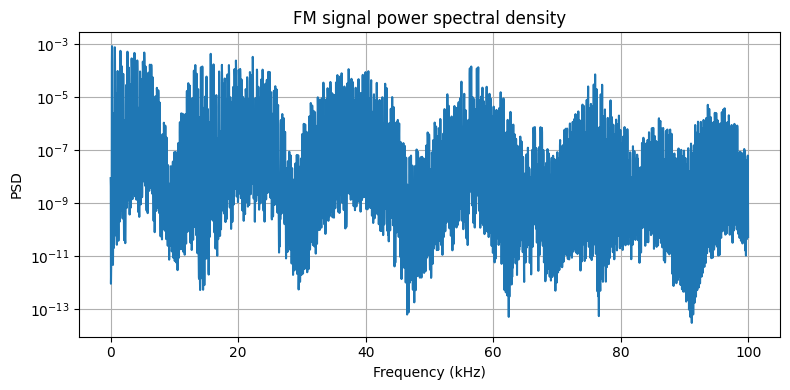

In [7]:
# Measure and plot bandwidth of the (real) FM signal
bw, f, psd = fm.measure_bandwidth_99(np.real(fm_signal), fs_comp)
print(f'Measured 99% bandwidth: {bw/1e3:.1f} kHz')
plt.figure(figsize=(8,4))
plt.semilogy(f/1e3, psd)
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD')
plt.title('FM signal power spectral density')
plt.grid(True)
plt.tight_layout()
plt.show()

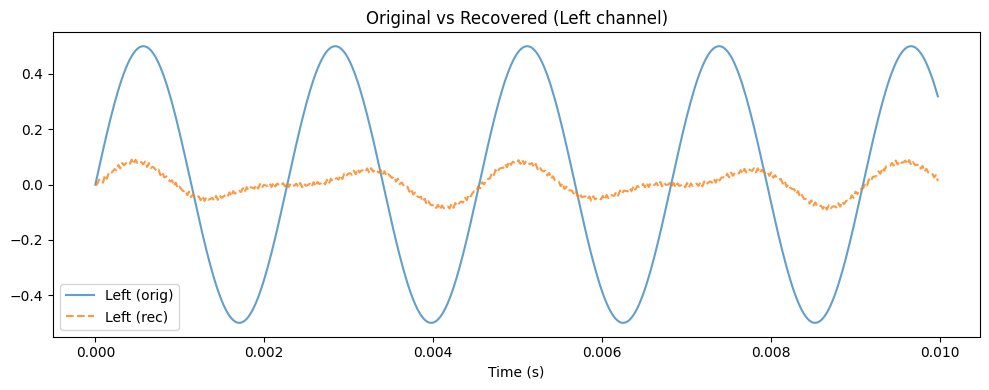

In [8]:
# Plot original vs recovered (first 0.01 s zoom)
zoom_t = 0.01
n_zoom = int(zoom_t * fs)
plt.figure(figsize=(10,4))
plt.plot(t[:n_zoom], left[:n_zoom], label='Left (orig)', alpha=0.7)
plt.plot(t[:n_zoom], left_rx[:n_zoom], label='Left (rec)', linestyle='--', alpha=0.8)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Original vs Recovered (Left channel)')
plt.tight_layout()
plt.show()